<a href="https://colab.research.google.com/github/MLcmore2023/MLcmore2023/blob/main/day10_am_morning/InvaderDefenderEnv_MinimaxQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange
import time

### Invader Defender Game:

- Time is broken up into discrete epochs.
- The world is a square area that is broken up into a 6-by-6 grid of cells.
- There are two players or agents; both of them can move up, down, left, or right. At each time step, both players take their action simultaneously. Each cannot see the others' action at that time step, but the state of the system and previous actions are fully observable to each. If the chosen action takes an agent outside of the grid, then the agent remains in the current position.
- The invader, marked I, starts in the upper-left corner of the world. The defender, marked D, starts in the bottom-left corner of the world.
- The 9 cells centered around the defender's current position (see Figure 1), is the region where the invader will be captured. The game ends whenever the invader is captured by the defender, or the invader enters the fixed territory cell marked T, whichever comes first.The discount factor for future rewards is $\gamma= 0.95$.
- The goal of the defender is to capture the invader as far away as possible from the territory T. The goal of the invader is to move as close as possible to the territory T before being captured.

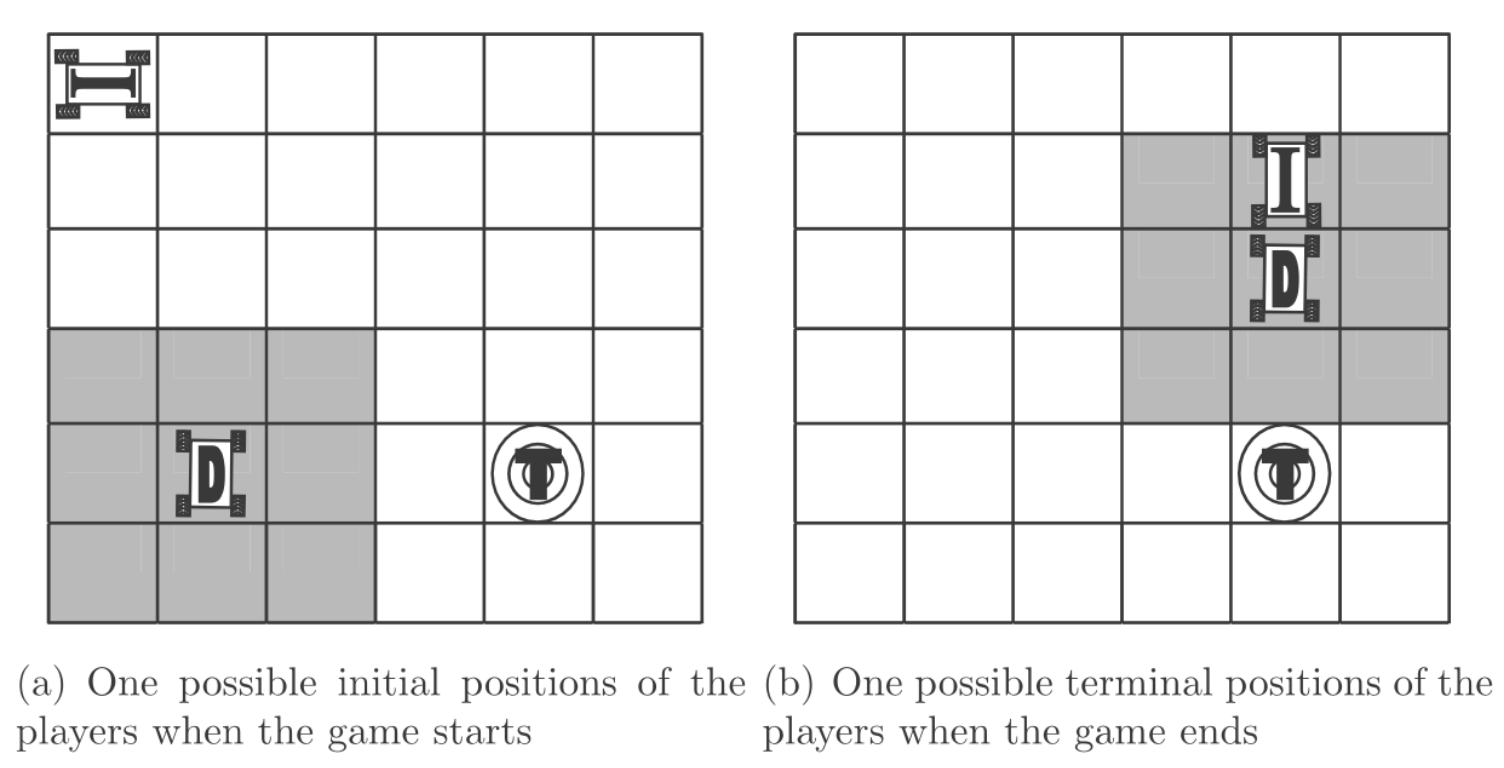


In [3]:
class InvaderDefenderEnv:
    ACTIONS = [(0, 1), (0, -1), (1, 0), (-1, 0)]  # RIGHT, LEFT, DOWN, UP

    def __init__(self, grid_size=9, target=None):
        self.grid_size = grid_size
        if target:
          self.target = target
        else:
          self.target = (self.grid_size - 1, self.grid_size - 1) # Lower right corner
        self.reset()

    def reset(self):
        self.invader_pos = [0, 0]
        self.defender_pos = [self.grid_size - 1, 0]
        self.done = False
        return self.invader_pos, self.defender_pos

    def is_capture(self):
        return abs(self.invader_pos[0] - self.defender_pos[0]) <= 1 and abs(self.invader_pos[1] - self.defender_pos[1]) <= 1

    def step(self, invader_action, defender_action):
        if not self.done:
            self.invader_pos = self.move(self.invader_pos, invader_action)
            self.defender_pos = self.move(self.defender_pos, defender_action)

            if self.is_capture():
                reward = -10
                self.done = True
                return (self.invader_pos, self.defender_pos), reward, self.done

            if tuple(self.invader_pos) == self.target:
                reward = 10
                self.done = True
                return (self.invader_pos, self.defender_pos), reward, self.done

        return (self.invader_pos, self.defender_pos), -1, self.done

    def move(self, current_pos, action):
        new_pos = (current_pos[0] + action[0], current_pos[1] + action[1])
        # Ensure new position is inside grid boundaries
        new_pos = (min(max(new_pos[0], 0), self.grid_size - 1), min(max(new_pos[1], 0), self.grid_size - 1))
        return new_pos

    @property
    def state(self):
        return self.invader_pos, self.defender_pos


In [4]:
from IPython import display


def visualize(env, ax):
    ax.clear()

    grid = np.zeros((env.grid_size, env.grid_size))

    # Marking invader and defender positions
    grid[env.invader_pos] = 1  # Invader
    grid[env.defender_pos] = 2  # Defender

    # Marking territory 'T'
    grid[env.target] = 3

    # Highlight capture area around the defender (3x3 grid)
    capture_cells = []
    for i in range(-1, 2):
        for j in range(-1, 2):
            x, y = env.defender_pos[0] + i, env.defender_pos[1] + j
            if 0 <= x < env.grid_size and 0 <= y < env.grid_size:  # Ensuring within grid bounds
                grid[x, y] = 4
                capture_cells.append((x, y))

    # Compute the center of the capture area
    center_x = sum(cell[1] for cell in capture_cells) / len(capture_cells)
    center_y = sum(cell[0] for cell in capture_cells) / len(capture_cells)

    # Setting color map
    cmap = plt.get_cmap('tab20c', 5)
    ax.matshow(grid, cmap=cmap)

    # Setting Invader, Defender, and Territory labels
    ax.text(env.invader_pos[1], env.invader_pos[0], 'I', ha='center', va='center', color='k')
    ax.text(center_x, center_y, 'D', ha='center', va='center', color='k')
    ax.text(env.target[1], env.target[0], 'T', ha='center', va='center', color='k')

    display.display(plt.gcf())
    display.clear_output(wait=True)

### Implementation of Minimax Q-Learning

Minimax Q-learning is a reinforcement learning algorithm used in competitive, multi-agent environments. Unlike traditional Q-learning which is designed for single-agent environments, Minimax Q-learning extends the concepts of Q-learning to handle opponents by integrating the Minimax algorithm.

Minimax Q-learning aims to find optimal policies by assuming that all agents (like both the player and its opponent) will act optimally. In simpler terms, it assumes the worst-case scenario: given a policy you've chosen, your opponent will choose a policy to minimize your expected reward.

### Pseudocode

```
Initialize Q(s, a, o) arbitrarily for each state-action-opponent_action triplet

Repeat (for each episode):
    Initialize state s
    Choose an action a using some exploration policy based on Q (like ε-greedy)
    Observe opponent's action o
    Take action a, observe reward r and new state s'
    Update Q-value using Minimax Q-learning rule:
        Q(s, a, o) = Q(s, a, o) + α [r + γ * V(s') - Q(s, a, o)]
    s = s'

Where:
V(s) = min_o max_a Q(s, a, o)
```

### Formulation:

The Q-value update rule for Minimax Q-learning can be formulated as:

$ Q(s, a, o) \leftarrow Q(s, a, o) + \alpha \left[ r + \gamma V(s') - Q(s, a, o) \right] $

Where:

- $ s $ is the current state
- $ a $ is the agent's action
- $ o $ is the opponent's action
- $ r $ is the immediate reward after taking action $ a $ and opponent taking action $ o $ in state $ s $
- $ \alpha $ is the learning rate
- $ \gamma $ is the discount factor

And the value function $ V(s) $ is defined as:

$ V(s) = \min_o \max_a Q(s, a, o) $

This value function represents the worst-case expected value for a given state, assuming that the opponent chooses action $ o $ to minimize the agent's expected reward, and the agent subsequently chooses action $ a $ to maximize its own expected reward.

### Explanation:

The Minimax Q-learning update is quite similar to the traditional Q-learning update, but it takes into consideration the opponent's action. Instead of just calculating the expected reward for the next state $ s' $ based on the best action $ a $ the agent can take, Minimax Q-learning also factors in the action $ o $ that the opponent can take to minimize the agent's reward.

The value function $ V(s) $ is defined as the minimum over the opponent's actions of the maximum over the agent's actions of $ Q(s, a, o) $. This captures the essence of the Minimax algorithm: the agent tries to maximize its expected reward while assuming that the opponent tries to minimize it.

In [11]:
class MinimaxQAgent:
    def __init__(self, learning_rate=0.1, discount_factor=0.9, epsilon=1.0):
        self.Q = {}
        self.epsilon = epsilon
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor

    def get_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            return InvaderDefenderEnv.ACTIONS[np.random.choice(len(InvaderDefenderEnv.ACTIONS))]
        q_values = [self.get_q_value(state, action) for action in InvaderDefenderEnv.ACTIONS]
        return InvaderDefenderEnv.ACTIONS[np.argmax(q_values)]

    def learn(self, state, action, reward, next_state):
        best_next_q_value = max([self.get_q_value(next_state, a) for a in InvaderDefenderEnv.ACTIONS])
        td_error = reward + self.discount_factor * best_next_q_value - self.get_q_value(state, action)
        self.update_q_value(state, action, self.get_q_value(state, action) + self.learning_rate * td_error)

    def get_q_value(self, state, action):
        return self.Q.get((tuple(state), tuple(action)), 0.0)

    def update_q_value(self, state, action, value):
        self.Q[(tuple(state), tuple(action))] = value

In [12]:
def train(invader, defender, episodes=1000):
    env = InvaderDefenderEnv()
    rewards = []

    for episode in trange(episodes):
        state = env.reset()
        episode_reward = 0

        while not env.done:
            invader_action = invader.get_action(state[0])
            defender_action = defender.get_action(state[1])

            next_state, reward, done = env.step(invader_action, defender_action)

            # Updating agents
            invader.learn(state[0], invader_action, reward, next_state[0])
            defender.learn(state[1], defender_action, -reward, next_state[1])

            state = next_state
            episode_reward += reward

        rewards.append(episode_reward)
        invader.epsilon = max(invader.epsilon * 0.995, 0.1)  # Decreasing exploration
        defender.epsilon = max(defender.epsilon * 0.995, 0.1)

    return rewards

  0%|          | 0/1000 [00:00<?, ?it/s]

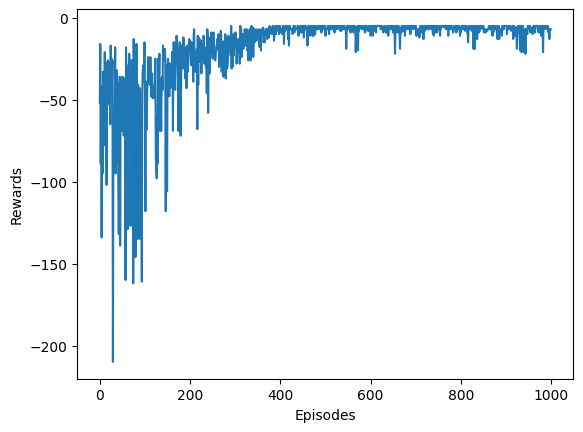

In [13]:
# Plot Rewards:
invader = MinimaxQAgent()
defender = MinimaxQAgent()

rewards = train(invader, defender, episodes=1000)
plt.plot(rewards)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.show()

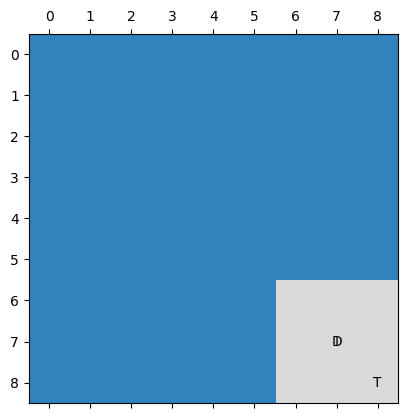

In [ ]:
fig, ax = plt.subplots()
done = False
env = InvaderDefenderEnv()
state = env.reset()
while not done:
    invader_action = invader.get_action(state[0])
    defender_action = defender.get_action(state[1])

    next_state, reward, done = env.step(invader_action, defender_action)

    state = next_state

    visualize(env, ax)

    time.sleep(0.1)